In [1]:
import rasterio as rio
from matplotlib import pyplot as plt
import numpy as np
from glob import glob
import os

from earthpy.spatial import stack
import xarray as xr

import pickle

# aggregating
from skimage.transform import rescale, resize, downscale_local_mean

# mapping
import cartopy
import cartopy.crs as ccrs

In [17]:
def lag_linregress_3D(x, y, lagx=0, lagy=0, n_obs=3):
    """
    https://hrishichandanpurkar.blogspot.com/2017/09/vectorized-functions-for-correlation.html
    Input: Two xr.Datarrays of any dimensions with the first dim being time. 
    Thus the input data could be a 1D time series, or for example, have three 
    dimensions (time,lat,lon). 
    
    Datasets can be provided in any order, but note that the regression slope 
    and intercept will be calculated for y with respect to x.
    
    
    Output: Covariance, correlation, regression slope and intercept, p-value, 
    and standard error on regression between the two datasets along their 
    aligned time dimension. 
    
    Lag values can be assigned to either of the data, with lagx shifting x, and
    lagy shifting y, with the specified lag amount. 
    """ 
    #1. Ensure that the data are properly alinged to each other. 
    x,y = xr.align(x,y)

    #2. Add lag information if any, and shift the data accordingly
    if lagx!=0:

        # If x lags y by 1, x must be shifted 1 step backwards. 
        # But as the 'zero-th' value is nonexistant, xr assigns it as invalid 
        # (nan). Hence it needs to be dropped
        x   = x.shift(time = -lagx).dropna(dim='time') 

        # Next important step is to re-align the two datasets so that y adjusts
        # to the changed coordinates of x
        x,y = xr.align(x,y)

    if lagy!=0:
        y   = y.shift(time = -lagy).dropna(dim='time')
        x,y = xr.align(x,y)

    #3. Compute data length, mean and standard deviation along time axis: X (1-D time) needs to be subset by non-NaN in Y
    n = y.notnull().sum(dim='time')
    n = xr.where(n<n_obs, np.nan, n) # pixels with less than n_obs set to NaN
    
    # retile 1-D array (assume X is time vector)
    x = np.expand_dims(np.expand_dims(x,-1), -1)
    x = np.tile(x, (1,y.shape[1], y.shape[2]))
    x = xr.where(y.notnull(), x, np.nan)
    
    xmean = x.mean(axis=0)
    ymean = y.mean(axis=0)
    xstd  = x.std(axis=0)
    ystd  = y.std(axis=0)

    #4. Compute covariance along time axis
    cov   =  np.sum((x - xmean)*(y - ymean), axis=0)/(n)

    #5. Compute correlation along time axis
    cor   = cov/(xstd*ystd)

    #6. Compute regression slope and intercept:
    slope     = cov/(xstd**2)
    intercept = ymean - xmean*slope  

    #7. Compute P-value and standard error
    #Compute t-statistics
    tstats = cor*np.sqrt(n-2)/np.sqrt(1-cor**2)
    stderr = slope/tstats

    from scipy.stats import t
    pval   = t.sf(tstats, n-2)*2
    pval   = xr.DataArray(pval, dims=cor.dims, coords=cor.coords)

    return cov,cor,slope,intercept,pval,stderr,n

def plot_regress_var(folder, af_var='FRP_total', reg_month='August', reg_var='slope', n_obsv=7, agg_fact=1, absmin=None, absmax=None, cm='jet', save=False, save_dir=None, cartoplot=False):
    
    var = af_var
    month= reg_month
    raster_folder = folder
    day_rasters = glob(raster_folder + '{}/*_D_*{}*.tif'.format(var, month))
    night_rasters = glob(raster_folder + '{}/*_N_*{}*.tif'.format(var, month))
    years = [int(os.path.basename(d).split('.')[0].split('_')[-1]) for d in day_rasters]

    test_day = xr.DataArray(stack(day_rasters, nodata=0)[0], dims=['time', 'lat', 'lon'])
    test_night = xr.DataArray(stack(night_rasters, nodata=0)[0], dims=['time', 'lat', 'lon'])
    test_years = xr.DataArray(np.arange(2001,2001+test_night.shape[0]), dims=['time'])
    
    d_cov, d_cor, d_slope, d_intercept, d_pval, d_stderr, d_n = lag_linregress_3D(test_years, test_day, n_obs=n_obsv)
    n_cov, n_cor, n_slope, n_intercept, n_pval, n_stderr, n_n = lag_linregress_3D(test_years, test_night, n_obs=n_obsv)
    
    if (absmin is None) or (absmax is None):
        absmin = min(n_slope.min(), d_slope.min())
        absmax = min(n_slope.max(), d_slope.max())
    
    
    night_plot_im = np.ma.masked_equal(n_slope,0)
    day_plot_im = np.ma.masked_equal(d_slope,0)


    # aggregate?
    agg_fac = agg_fact # agg_fac*0.25... 4 == 1 deg
    if agg_fac > 1:
        night_resized = resize(night_plot_im, (int(night_plot_im.shape[0] / agg_fac), int(night_plot_im.shape[1] / agg_fac)), anti_aliasing=True)
    else:
        night_resized = night_plot_im
    night_resized = np.ma.masked_equal(night_resized,0)

    if agg_fac > 1:
        day_resized = resize(day_plot_im, (int(day_plot_im.shape[0] / agg_fac), int(day_plot_im.shape[1] / agg_fac)), anti_aliasing=True)
    else:
        day_resized = day_plot_im
    day_resized = np.ma.masked_equal(day_resized,0)

    if not cartoplot:
        fig, ax = plt.subplots(2,1, figsize=(30,20))
        ax[0].imshow(day_resized, cmap=cm, vmin=absmin, vmax=absmax)
        ax[0].set_title('daytime slope for {} 2001-2019, at least {} data points'.format(month, n_obsv))
        im=ax[1].imshow(night_resized, cmap=cm, vmin=absmin, vmax=absmax)
        ax[1].set_title('nighttime slope for {} 2001-2019, at least {} data points'.format(month, n_obsv))

        fig.subplots_adjust(right=0.96)
        cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
        fig.colorbar(im, cax=cbar_ax)

        if save:
            save_file = os.path.join(save_dir, '{}_{}_slope_aggfact{}.png'.format(var, month, agg_fact))
            plt.savefig(save_file)

        plt.show()
        
    else:
        plot_carto(folder, day_resized, var, month, 'D', n_obsv, cm, absmin, absmax, agg_fact, save_dir=save_dir)
        plot_carto(folder, night_resized, var, month, 'N', n_obsv, cm, absmin, absmax, agg_fact, save_dir=save_dir)
    
def plot_carto(raster_folder, data, var, month, daynight, n_obsv, cmap, vmin, vmax, agg_fact, save=True, save_dir=None):
    
    # get coords
    ## try for my data
    template = glob(raster_folder + '{}/*_D_*{}*.tif'.format('AFC_num', 'April'))[0]
    with rio.open(template) as src:
        meta = src.meta

    tform = meta['transform']
    #num_x = meta['width']
    #num_y = meta['height']
    
    num_x = data.shape[1]
    num_y = data.shape[0]

    # incorporate aggregation factor
    tlon = np.linspace(tform.c - tform.a*agg_fact, tform.c+num_x*tform.a*agg_fact, num_x)
    tlat = np.linspace(tform.f - tform.e*agg_fact, tform.f+num_y*tform.e*agg_fact, num_y)
    lon2d, lat2d = np.meshgrid(tlon, tlat)

    
    
    xdata = xr.DataArray(data, coords=[tlat, tlon], dims=['lat', 'lon'])
    xdata = xr.where(xdata == 0, np.nan, xdata)

    fig = plt.figure(figsize=(20,10))
    ax = plt.axes(projection=ccrs.EqualEarth())
    ax.set_global()
    ax.coastlines()
    ax.gridlines()
    xdata.plot(ax=ax, transform=ccrs.PlateCarree(), cmap=cmap, vmin=vmin, vmax=vmax)
    
    if daynight=='D':
        title = '{} daytime slope for {} 2001-2019, at least {} data points'.format(var, month, n_obsv)
    else:
        title = '{} nighttime slope for {} 2001-2019, at least {} data points'.format(var, month, n_obsv)
        
    plt.title(title)
    
    if save:
        save_file = os.path.join(save_dir, '{}_{}_slope_aggfact{}_dn{}.png'.format(var, month, agg_fact, daynight))
        plt.savefig(save_file)
        
    plt.show()

*************************************************


C:\software\anaconda3\envs\eapy_gbdx\lib\site-packages\scipy\stats\_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\software\anaconda3\envs\eapy_gbdx\lib\site-packages\scipy\stats\_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\software\anaconda3\envs\eapy_gbdx\lib\site-packages\scipy\stats\_distn_infrastructure.py:1831: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


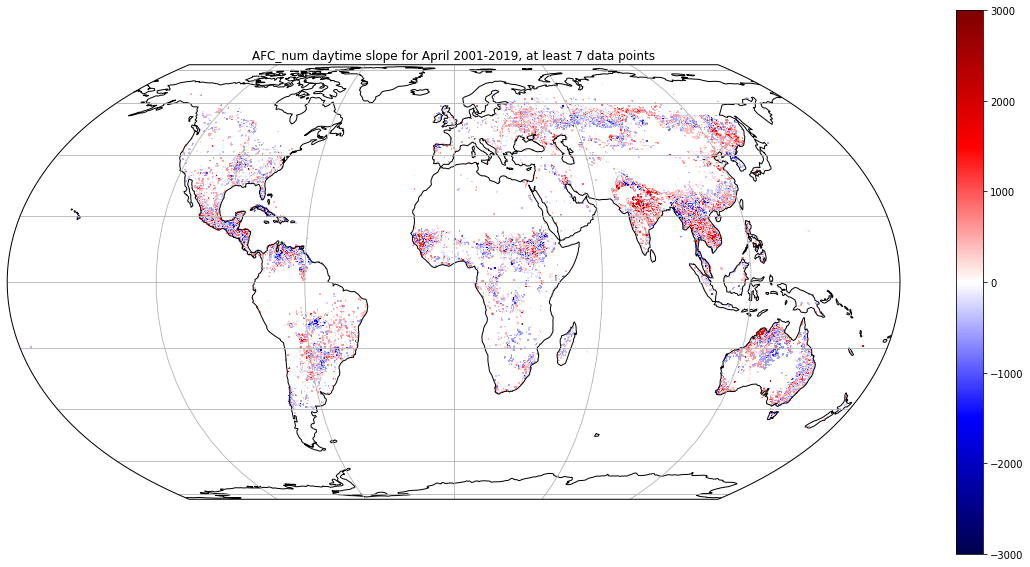

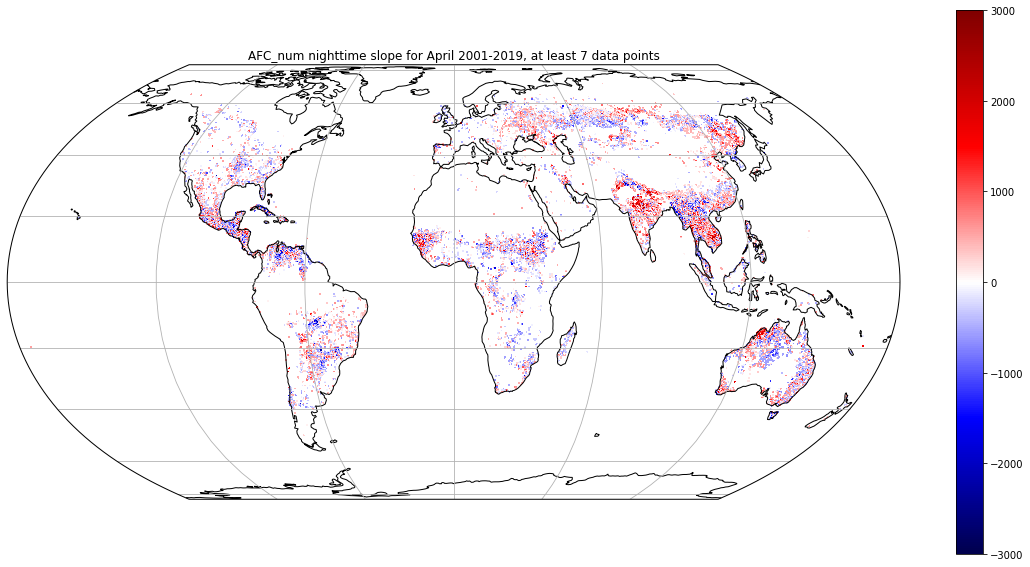

*************************************************
*************************************************


C:\software\anaconda3\envs\eapy_gbdx\lib\site-packages\scipy\stats\_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\software\anaconda3\envs\eapy_gbdx\lib\site-packages\scipy\stats\_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\software\anaconda3\envs\eapy_gbdx\lib\site-packages\scipy\stats\_distn_infrastructure.py:1831: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


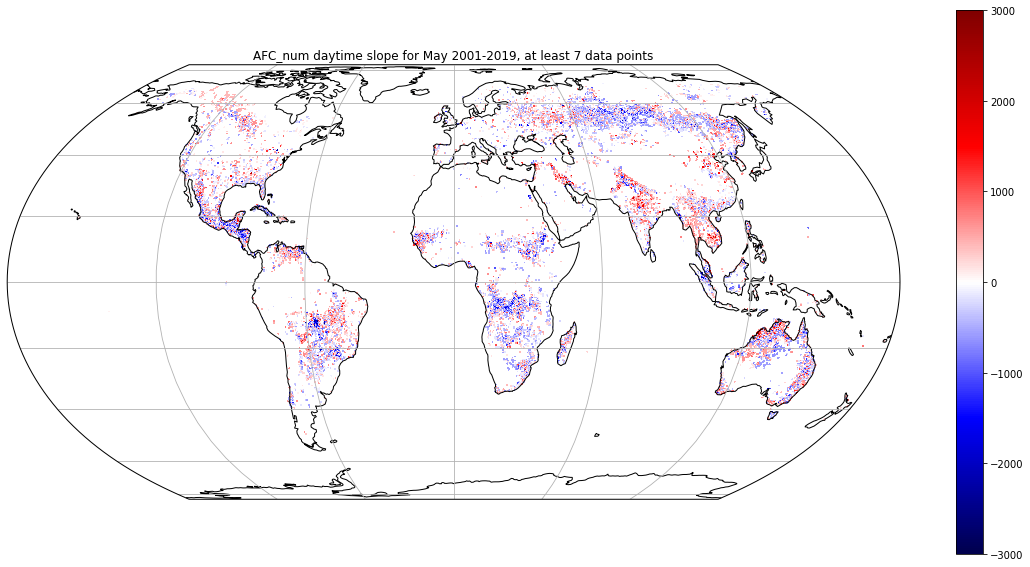

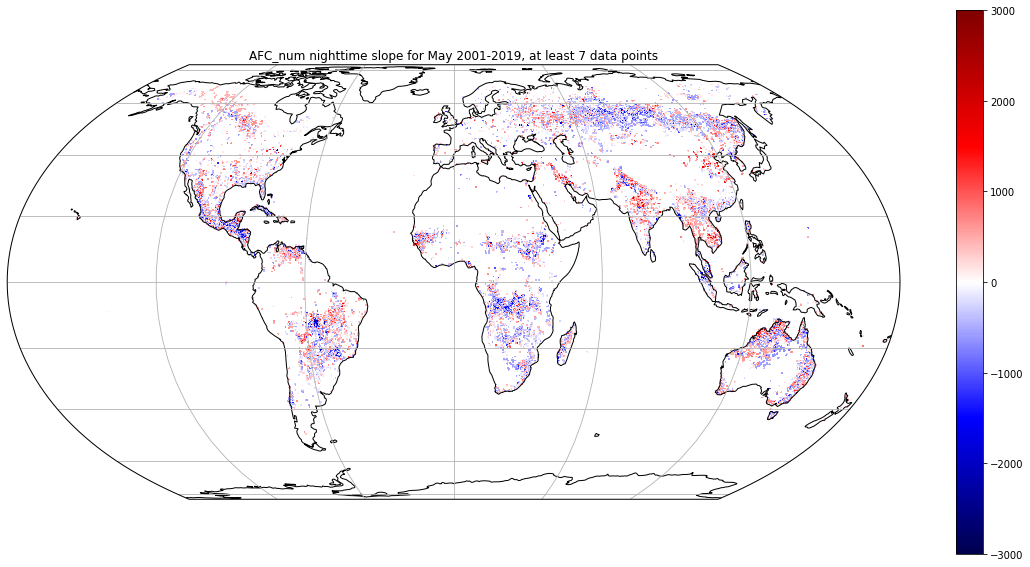

*************************************************
*************************************************


C:\software\anaconda3\envs\eapy_gbdx\lib\site-packages\scipy\stats\_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\software\anaconda3\envs\eapy_gbdx\lib\site-packages\scipy\stats\_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\software\anaconda3\envs\eapy_gbdx\lib\site-packages\scipy\stats\_distn_infrastructure.py:1831: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


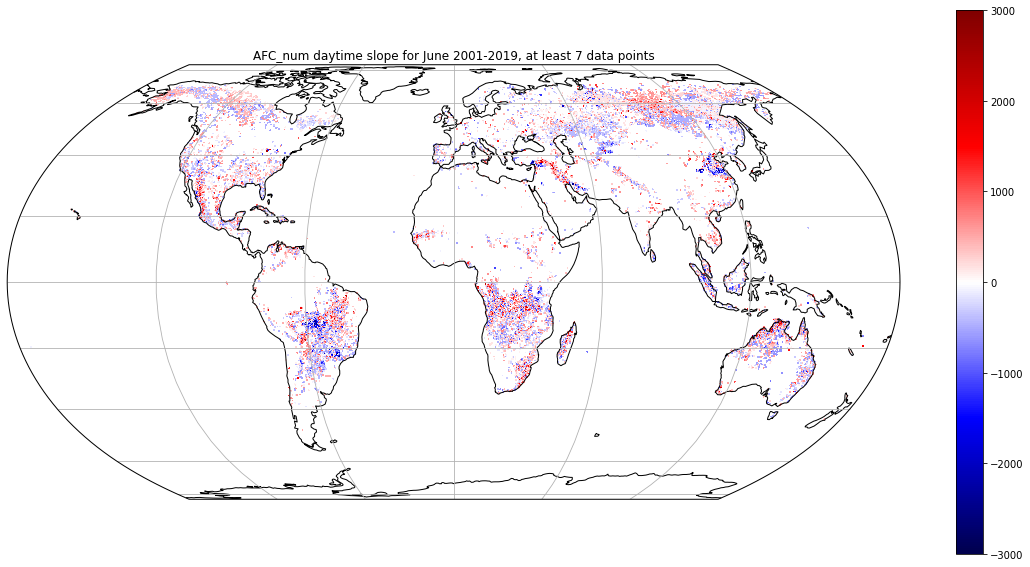

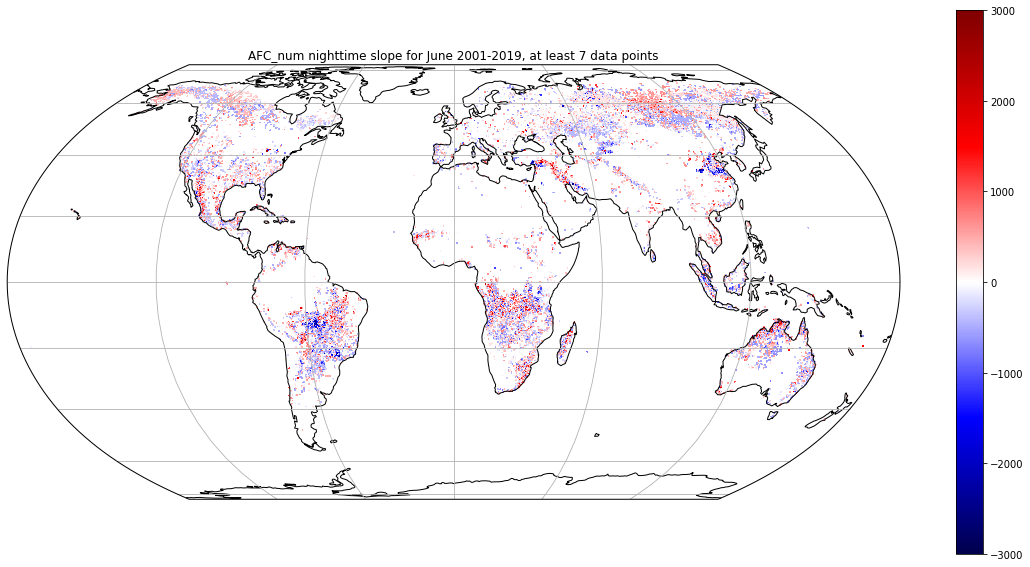

*************************************************
*************************************************


C:\software\anaconda3\envs\eapy_gbdx\lib\site-packages\scipy\stats\_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\software\anaconda3\envs\eapy_gbdx\lib\site-packages\scipy\stats\_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\software\anaconda3\envs\eapy_gbdx\lib\site-packages\scipy\stats\_distn_infrastructure.py:1831: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


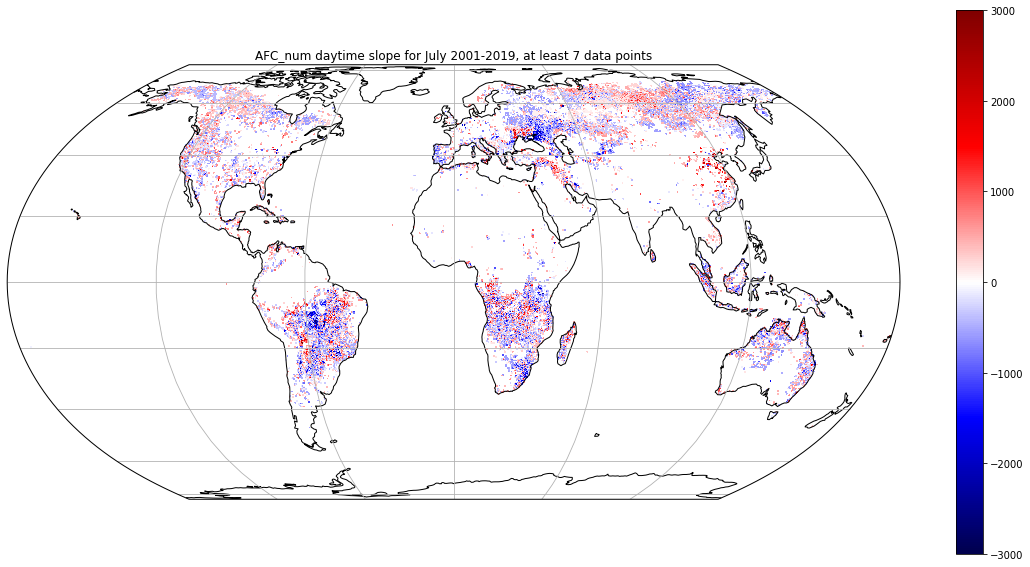

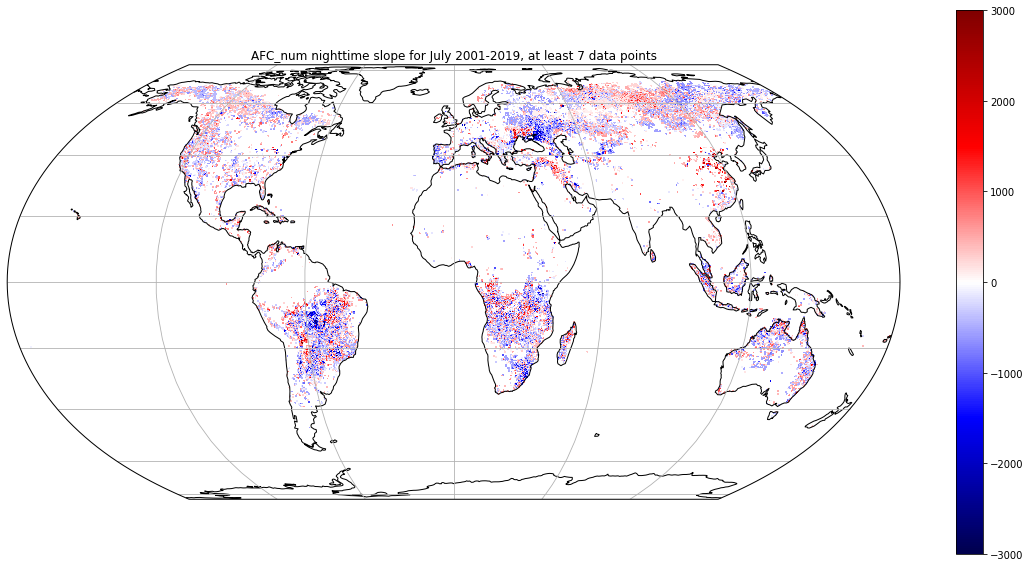

*************************************************
*************************************************


C:\software\anaconda3\envs\eapy_gbdx\lib\site-packages\scipy\stats\_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\software\anaconda3\envs\eapy_gbdx\lib\site-packages\scipy\stats\_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\software\anaconda3\envs\eapy_gbdx\lib\site-packages\scipy\stats\_distn_infrastructure.py:1831: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


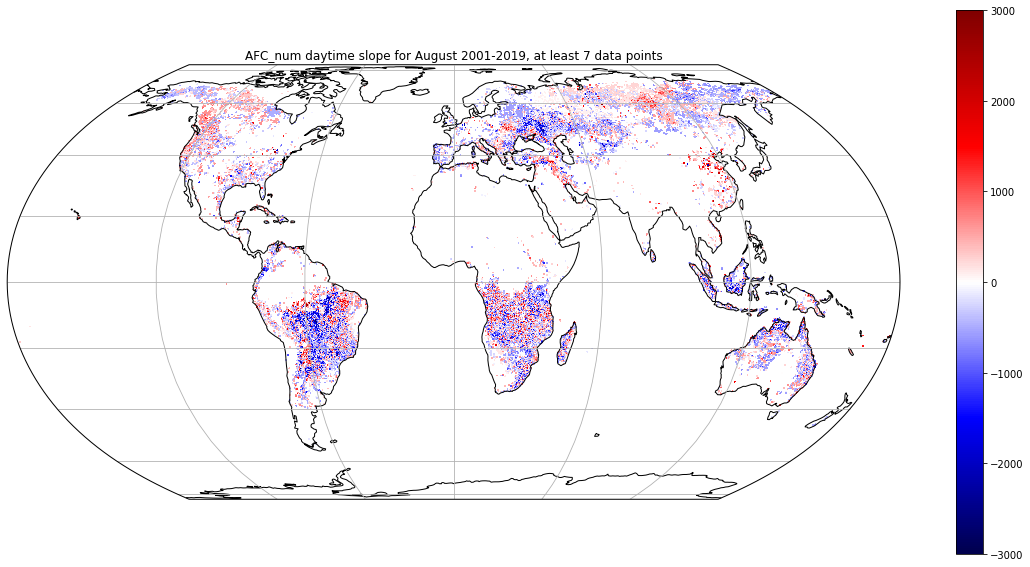

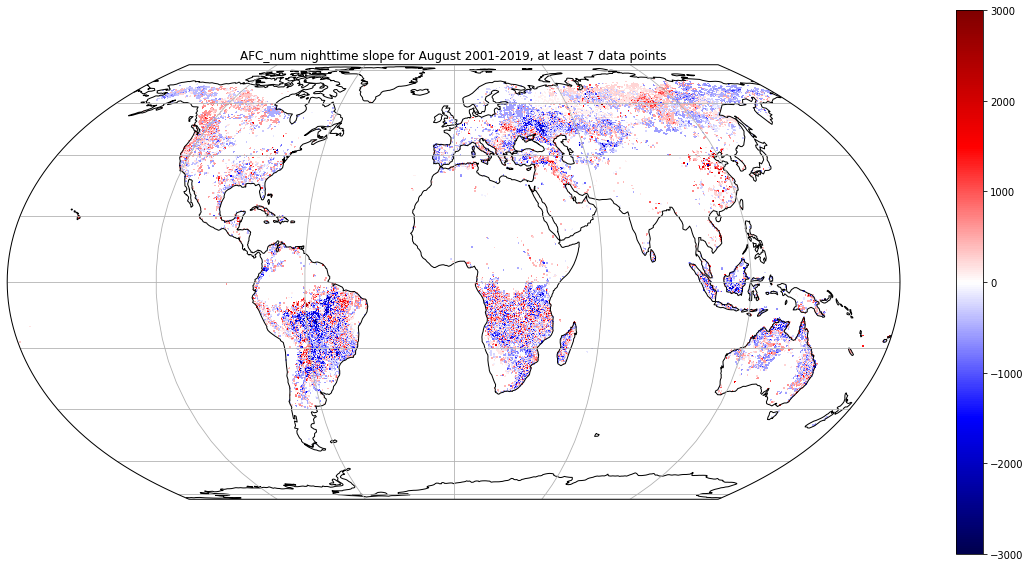

*************************************************
*************************************************


C:\software\anaconda3\envs\eapy_gbdx\lib\site-packages\scipy\stats\_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\software\anaconda3\envs\eapy_gbdx\lib\site-packages\scipy\stats\_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\software\anaconda3\envs\eapy_gbdx\lib\site-packages\scipy\stats\_distn_infrastructure.py:1831: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


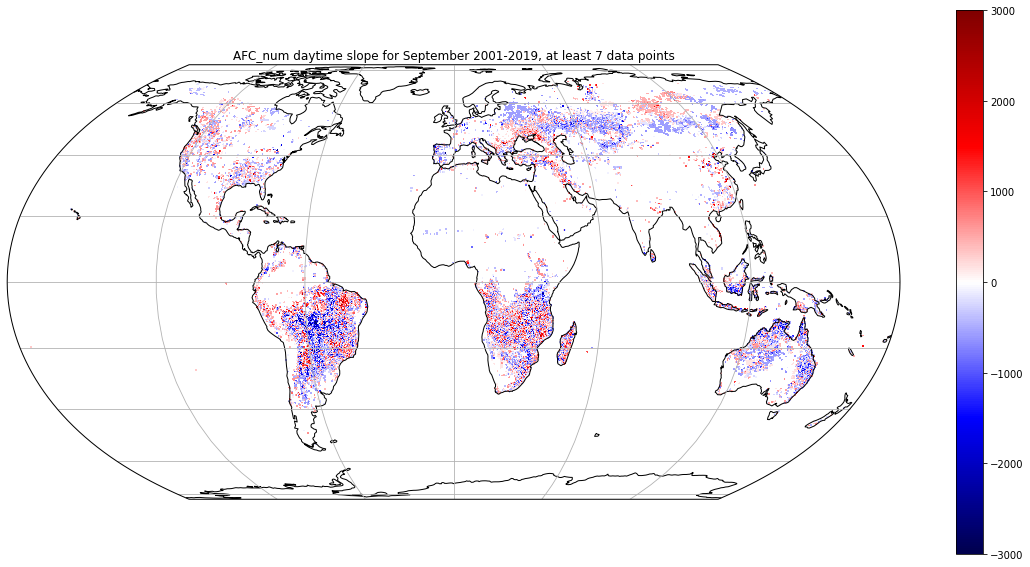

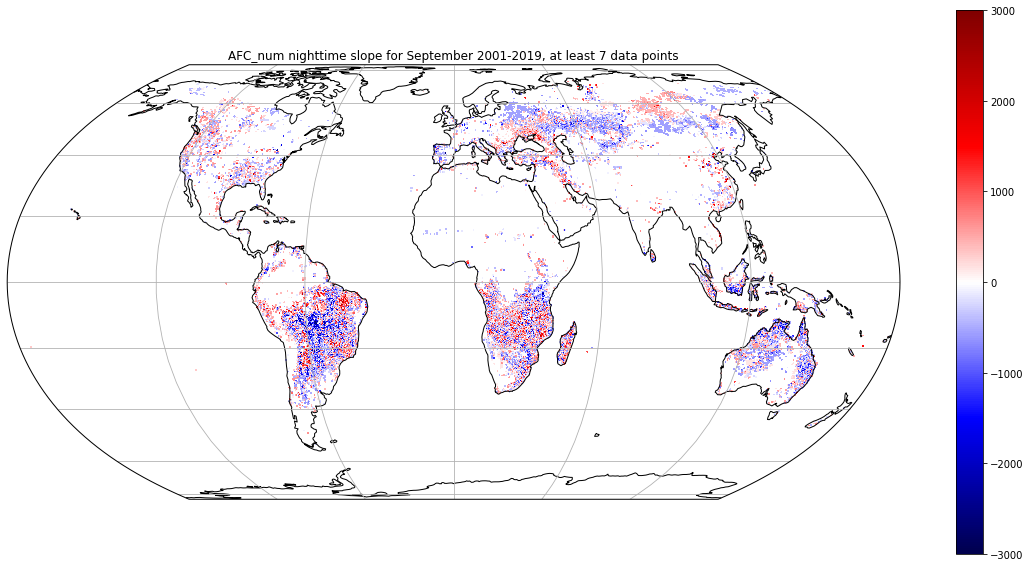

*************************************************
*************************************************


C:\software\anaconda3\envs\eapy_gbdx\lib\site-packages\scipy\stats\_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\software\anaconda3\envs\eapy_gbdx\lib\site-packages\scipy\stats\_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\software\anaconda3\envs\eapy_gbdx\lib\site-packages\scipy\stats\_distn_infrastructure.py:1831: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


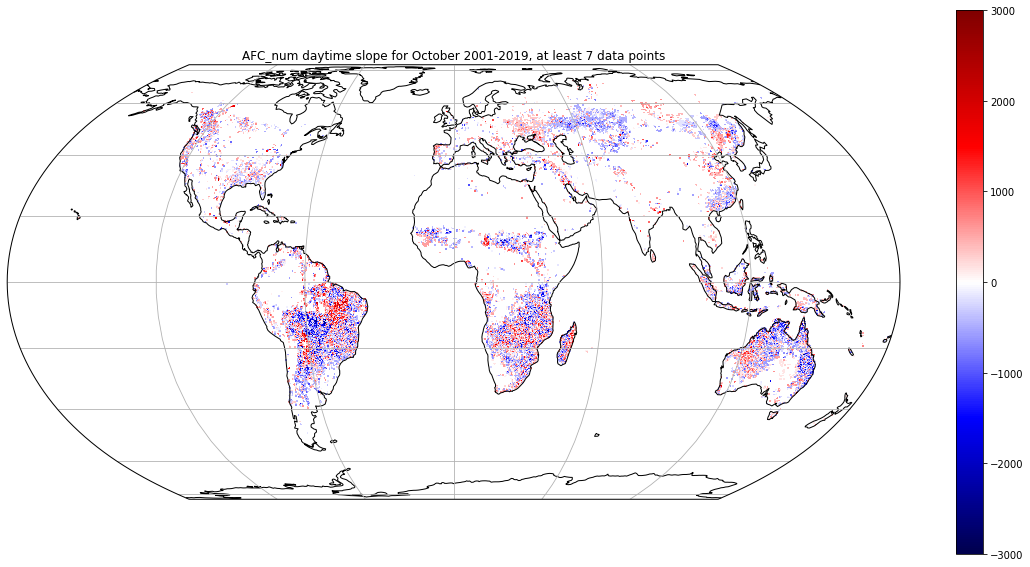

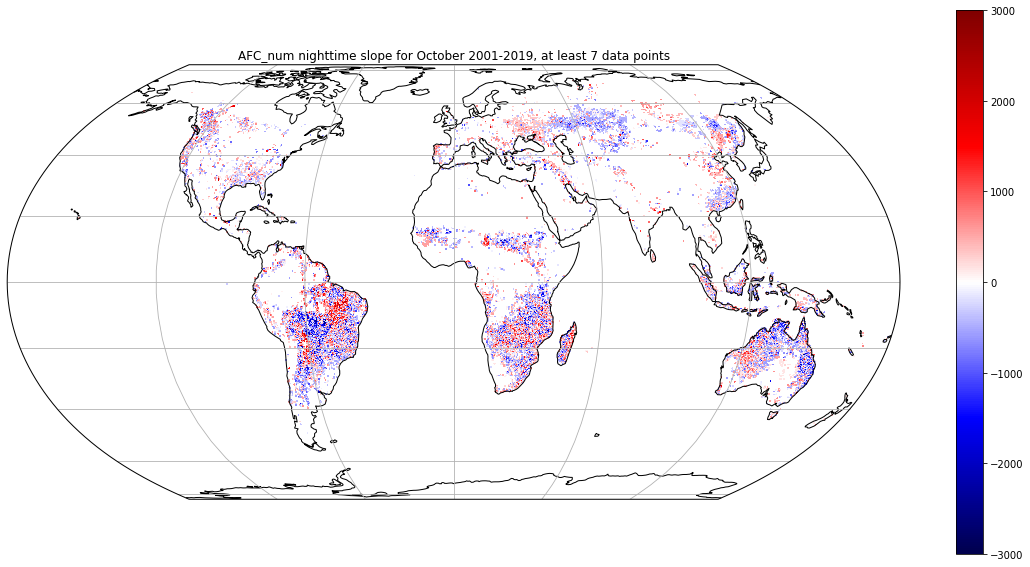

*************************************************
*************************************************


C:\software\anaconda3\envs\eapy_gbdx\lib\site-packages\scipy\stats\_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\software\anaconda3\envs\eapy_gbdx\lib\site-packages\scipy\stats\_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\software\anaconda3\envs\eapy_gbdx\lib\site-packages\scipy\stats\_distn_infrastructure.py:1831: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


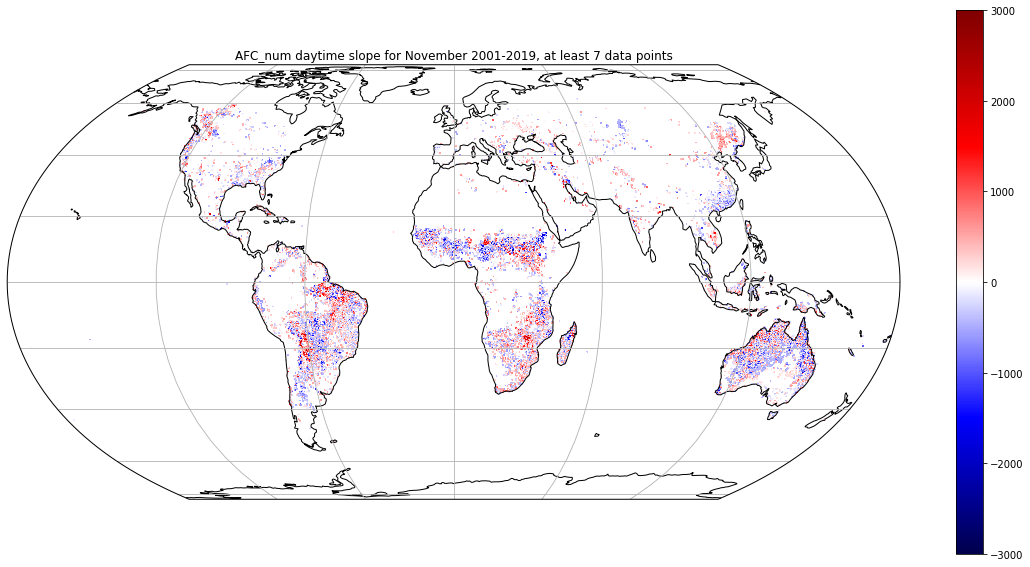

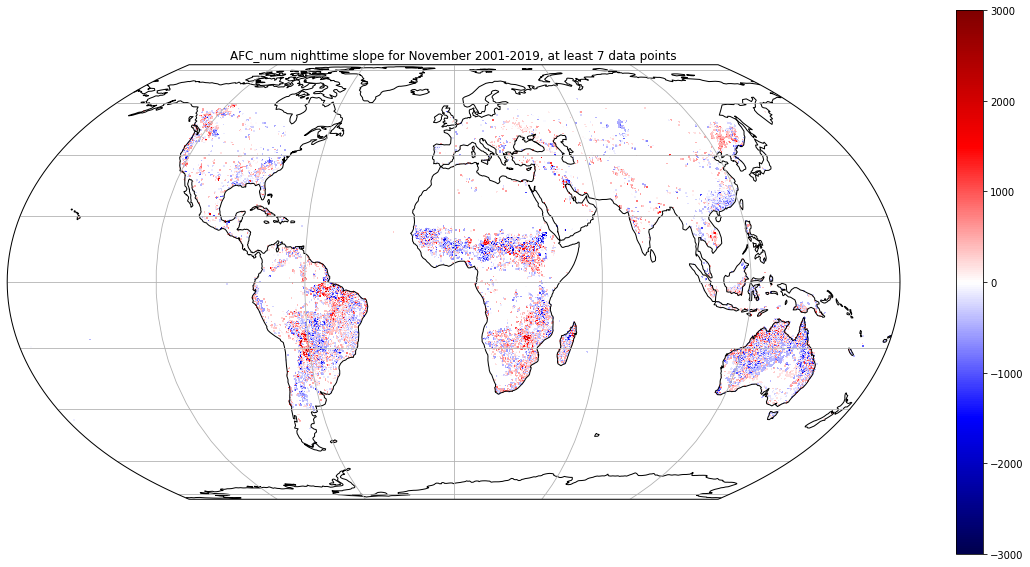

*************************************************


In [22]:
raster_folder = r"D:/projects/RD/night_fire/grid_0_25_degree_vars_2/"
raster_folder = r"D:/projects/RD/night_fire/vars/grid_0_25_degree_vars/" # data refresh!

var = 'AFC_num'
n=7
fig_folder = r"D:/projects/RD/night_fire/figs/slopes_refresh/{}_0_25_numobs{}".format(var, n)

if not os.path.exists(fig_folder):
    os.makedirs(fig_folder)
    
    
cm = 'seismic'
for month in ['April', 'May', 'June', 'July', 'August', 'September', 'October', 'November']:
    print('*************************************************')
    plot_regress_var(raster_folder, af_var='AFC_num', reg_month=month, reg_var='slope', n_obsv=n, agg_fact=1,
                    absmin=-3000, 
                    absmax=3000,
                    cm=cm,
                    save=True,
                    save_dir=fig_folder,
                    cartoplot=True)
    print('*************************************************')

# Do the same for 2.5 degree grids

*************************************************


C:\software\anaconda3\envs\eapy_gbdx\lib\site-packages\scipy\stats\_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\software\anaconda3\envs\eapy_gbdx\lib\site-packages\scipy\stats\_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\software\anaconda3\envs\eapy_gbdx\lib\site-packages\scipy\stats\_distn_infrastructure.py:1831: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


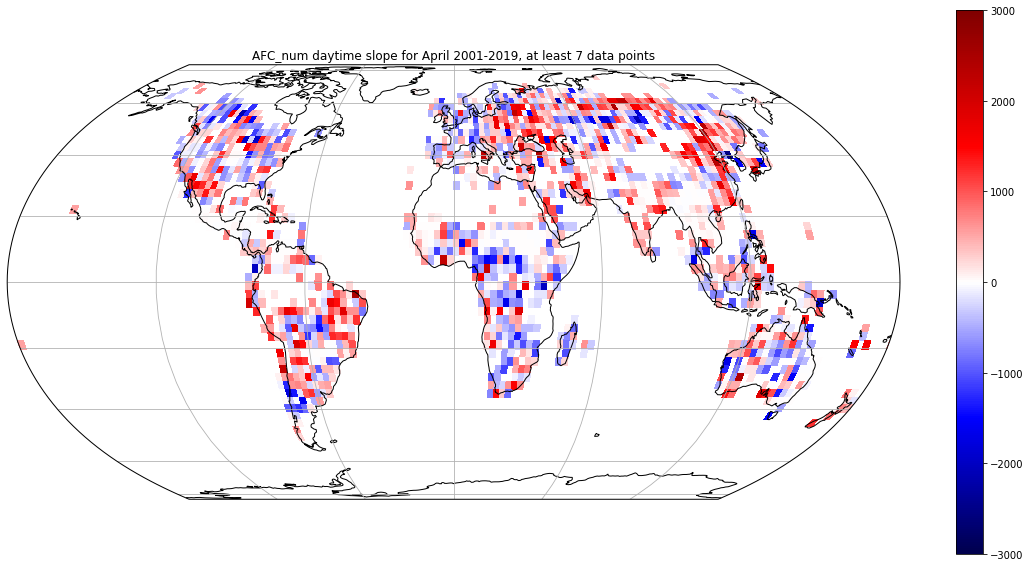

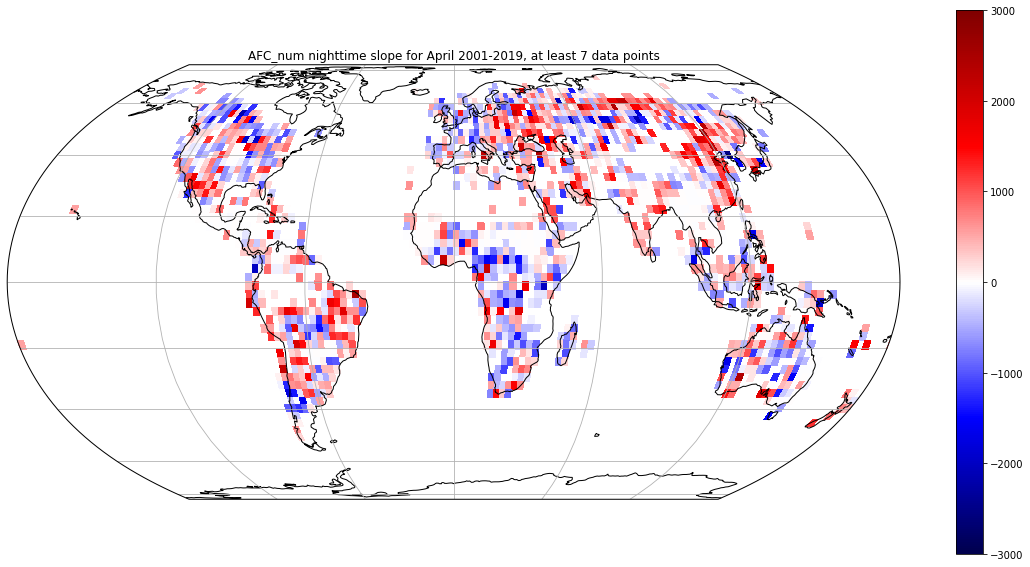

*************************************************
*************************************************


C:\software\anaconda3\envs\eapy_gbdx\lib\site-packages\scipy\stats\_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\software\anaconda3\envs\eapy_gbdx\lib\site-packages\scipy\stats\_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\software\anaconda3\envs\eapy_gbdx\lib\site-packages\scipy\stats\_distn_infrastructure.py:1831: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


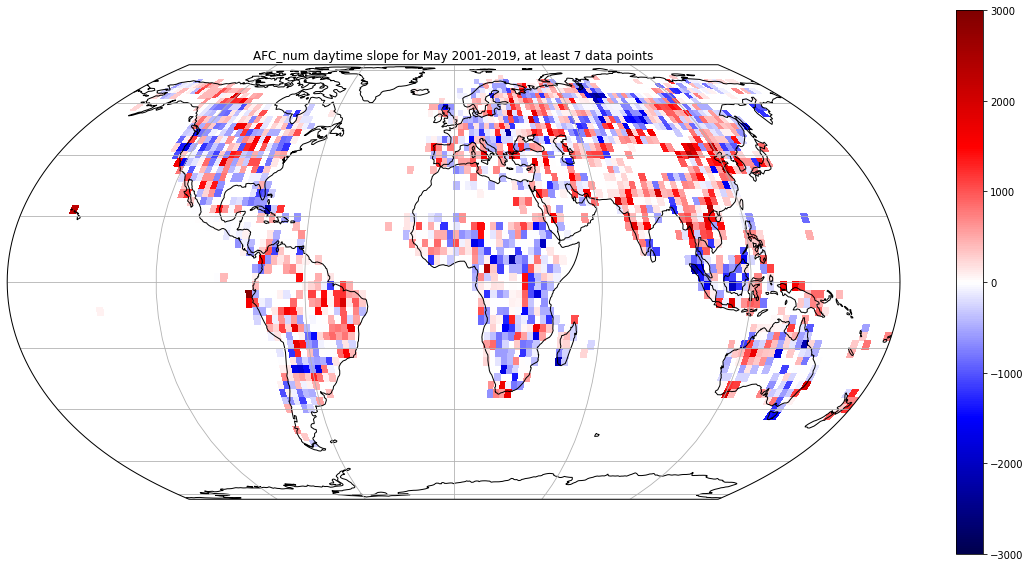

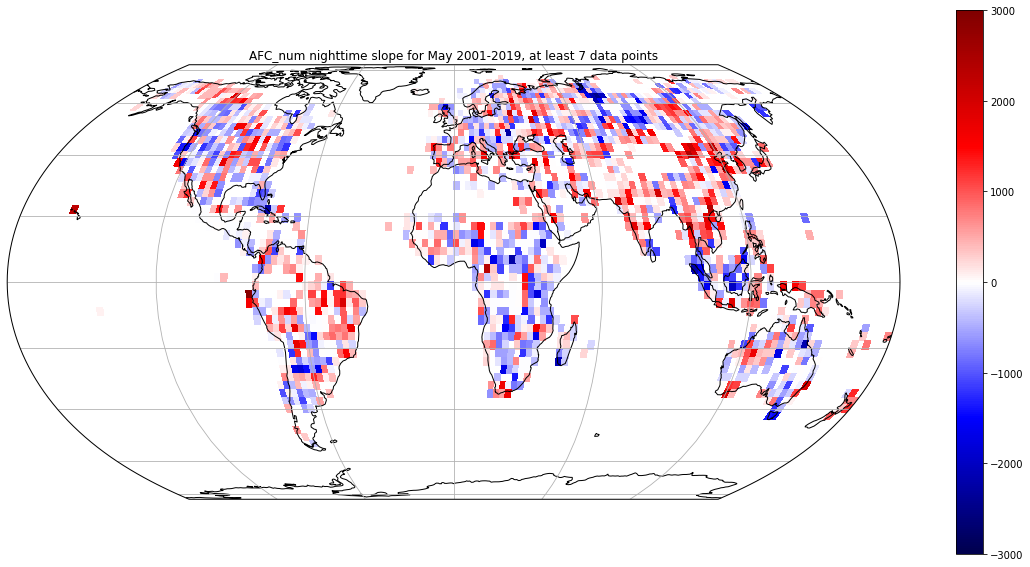

*************************************************
*************************************************


C:\software\anaconda3\envs\eapy_gbdx\lib\site-packages\scipy\stats\_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\software\anaconda3\envs\eapy_gbdx\lib\site-packages\scipy\stats\_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\software\anaconda3\envs\eapy_gbdx\lib\site-packages\scipy\stats\_distn_infrastructure.py:1831: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


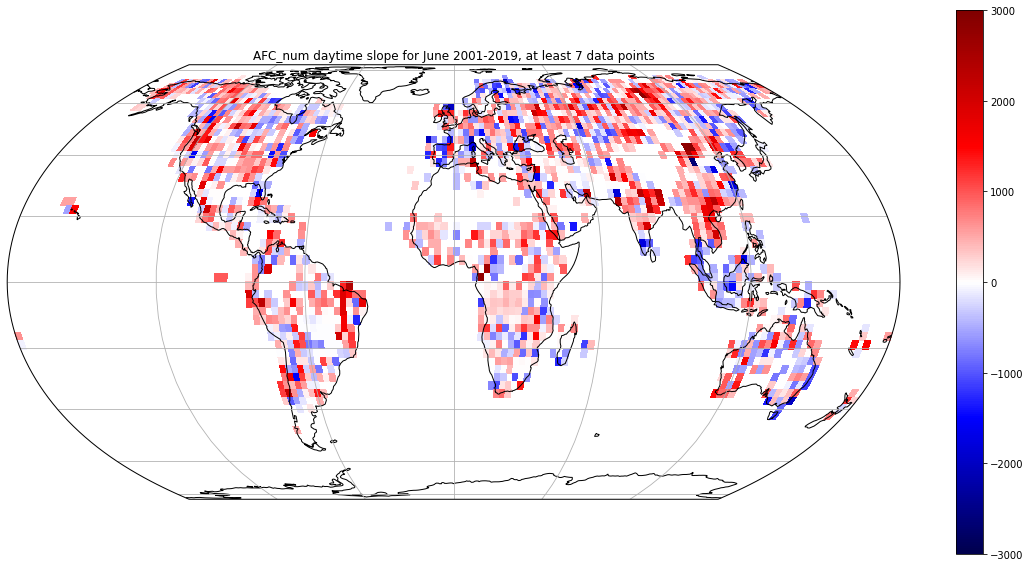

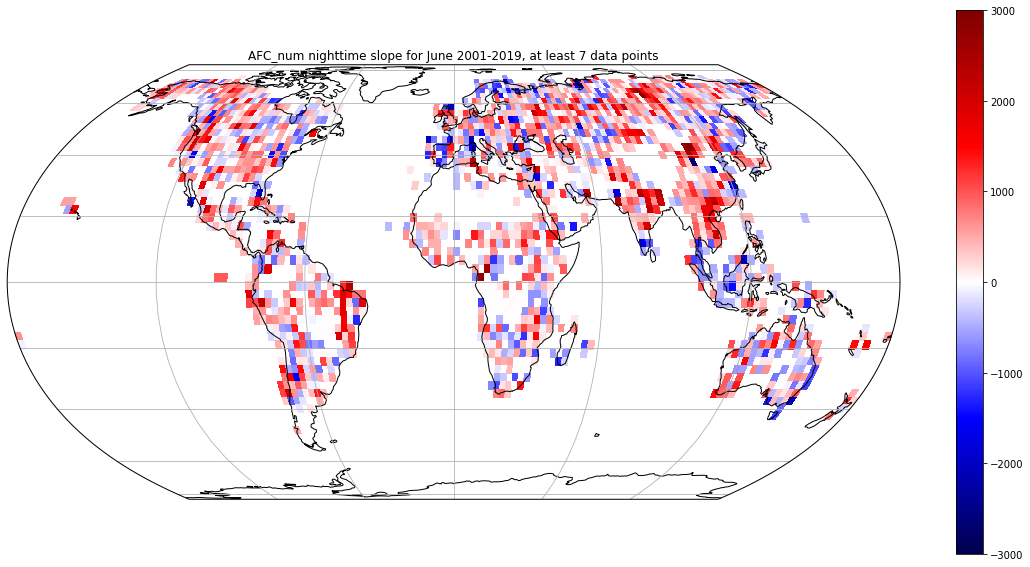

*************************************************
*************************************************


C:\software\anaconda3\envs\eapy_gbdx\lib\site-packages\scipy\stats\_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\software\anaconda3\envs\eapy_gbdx\lib\site-packages\scipy\stats\_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\software\anaconda3\envs\eapy_gbdx\lib\site-packages\scipy\stats\_distn_infrastructure.py:1831: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


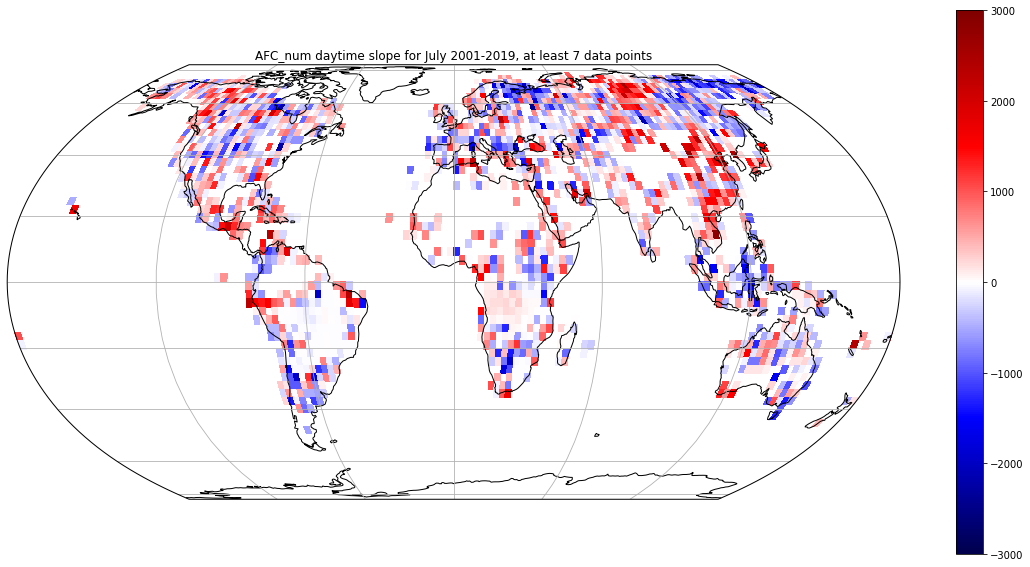

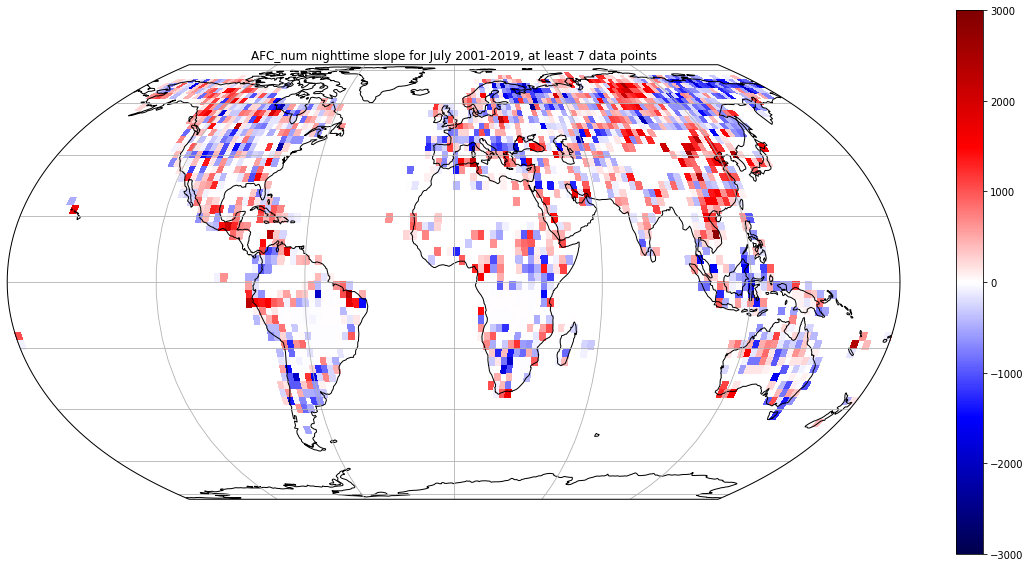

*************************************************
*************************************************


C:\software\anaconda3\envs\eapy_gbdx\lib\site-packages\scipy\stats\_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\software\anaconda3\envs\eapy_gbdx\lib\site-packages\scipy\stats\_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\software\anaconda3\envs\eapy_gbdx\lib\site-packages\scipy\stats\_distn_infrastructure.py:1831: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


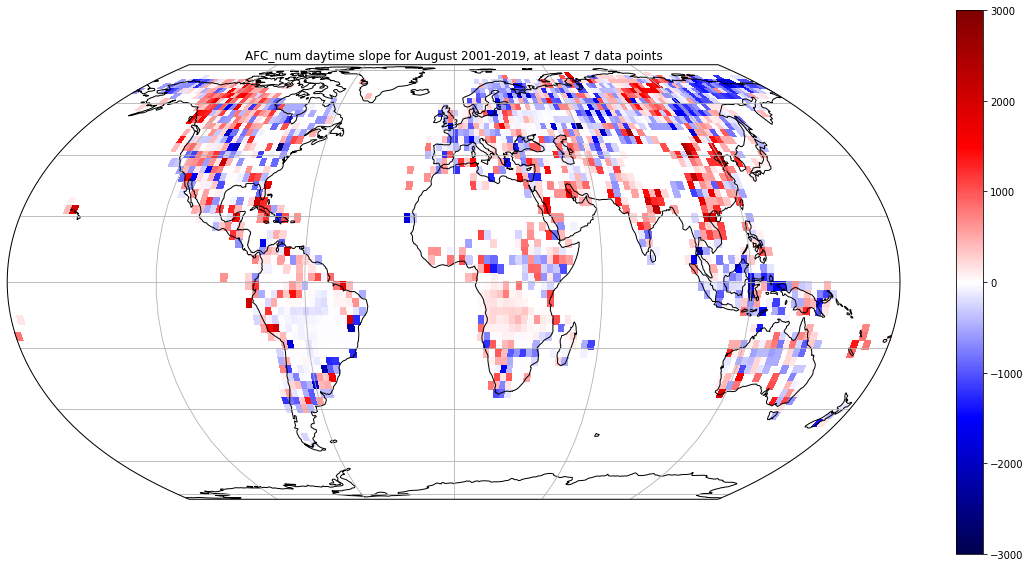

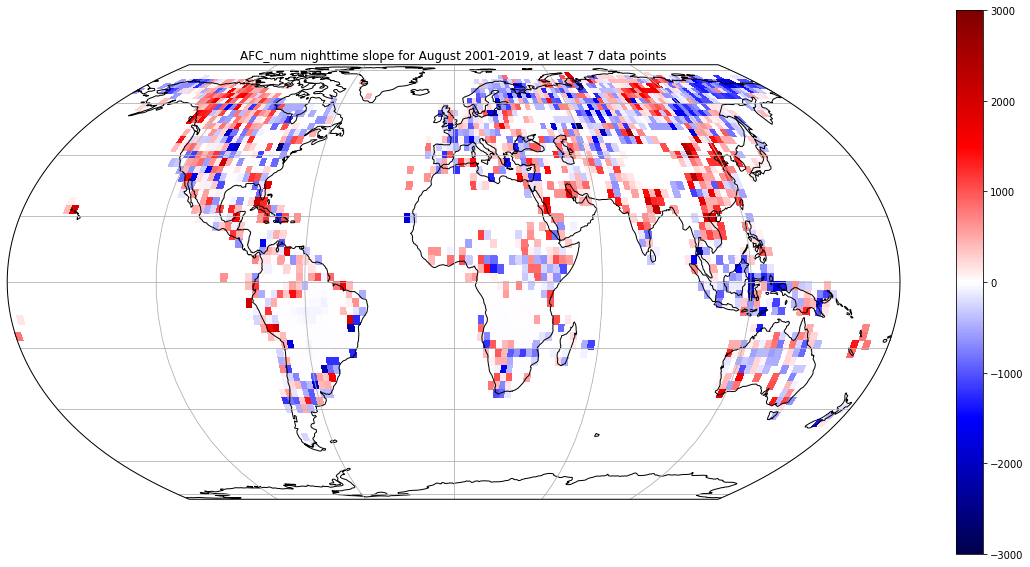

*************************************************
*************************************************


C:\software\anaconda3\envs\eapy_gbdx\lib\site-packages\scipy\stats\_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\software\anaconda3\envs\eapy_gbdx\lib\site-packages\scipy\stats\_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\software\anaconda3\envs\eapy_gbdx\lib\site-packages\scipy\stats\_distn_infrastructure.py:1831: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


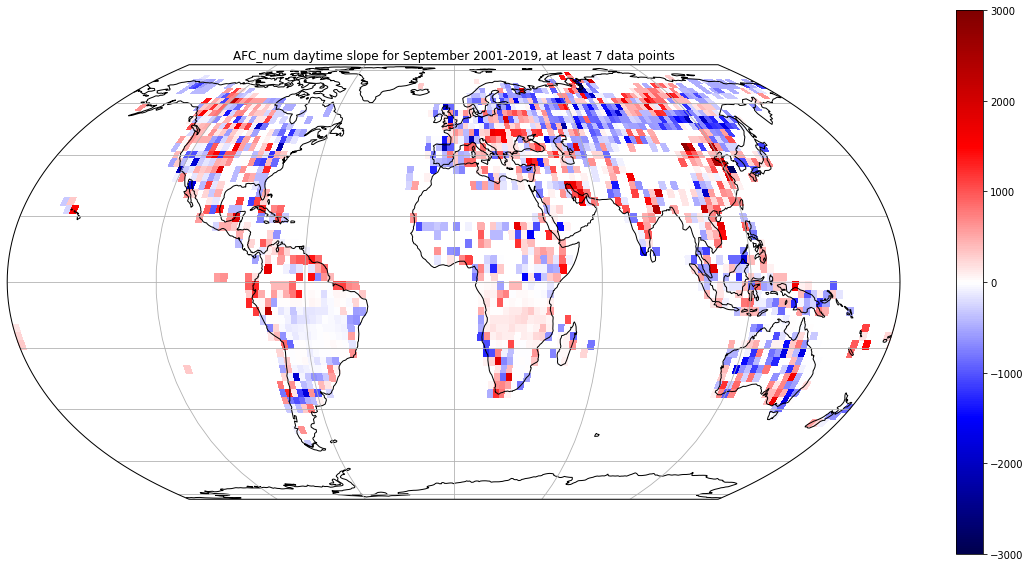

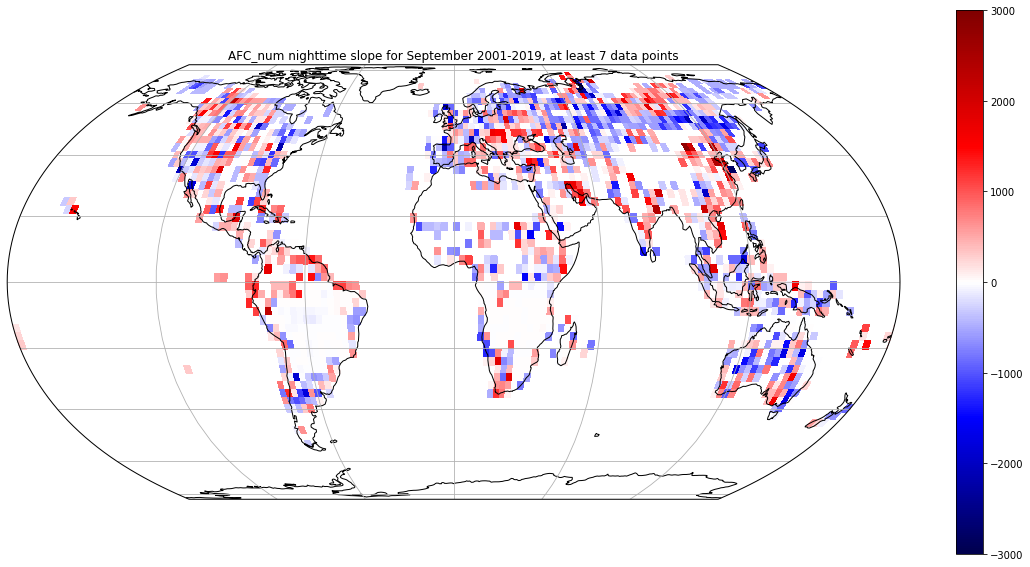

*************************************************
*************************************************


C:\software\anaconda3\envs\eapy_gbdx\lib\site-packages\scipy\stats\_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\software\anaconda3\envs\eapy_gbdx\lib\site-packages\scipy\stats\_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\software\anaconda3\envs\eapy_gbdx\lib\site-packages\scipy\stats\_distn_infrastructure.py:1831: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


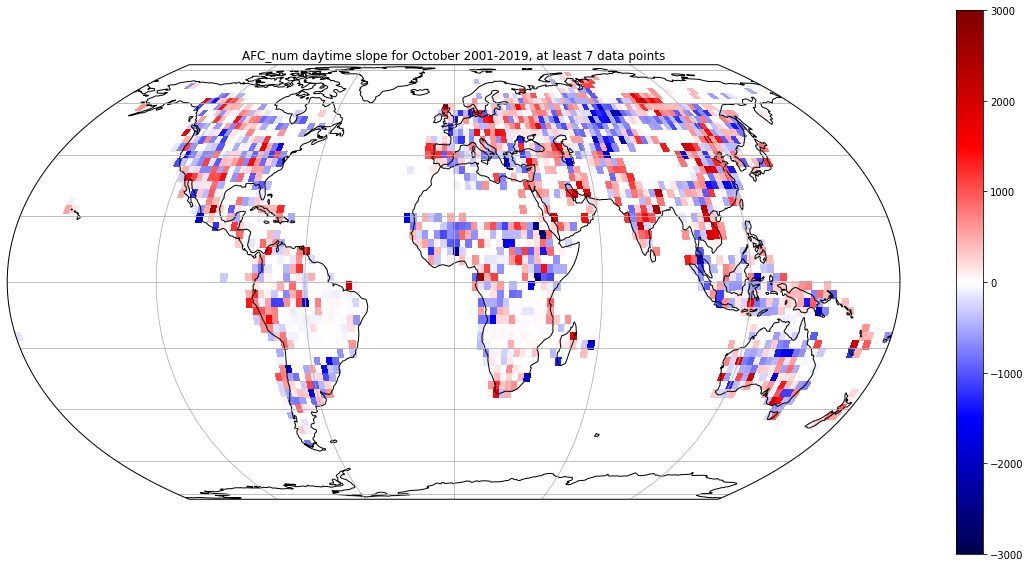

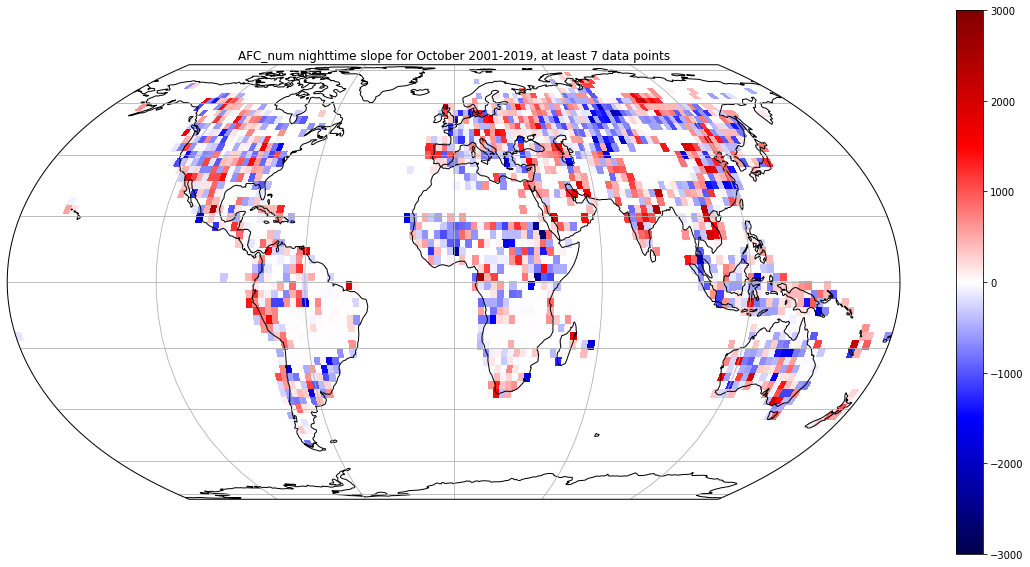

*************************************************
*************************************************


C:\software\anaconda3\envs\eapy_gbdx\lib\site-packages\scipy\stats\_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\software\anaconda3\envs\eapy_gbdx\lib\site-packages\scipy\stats\_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\software\anaconda3\envs\eapy_gbdx\lib\site-packages\scipy\stats\_distn_infrastructure.py:1831: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


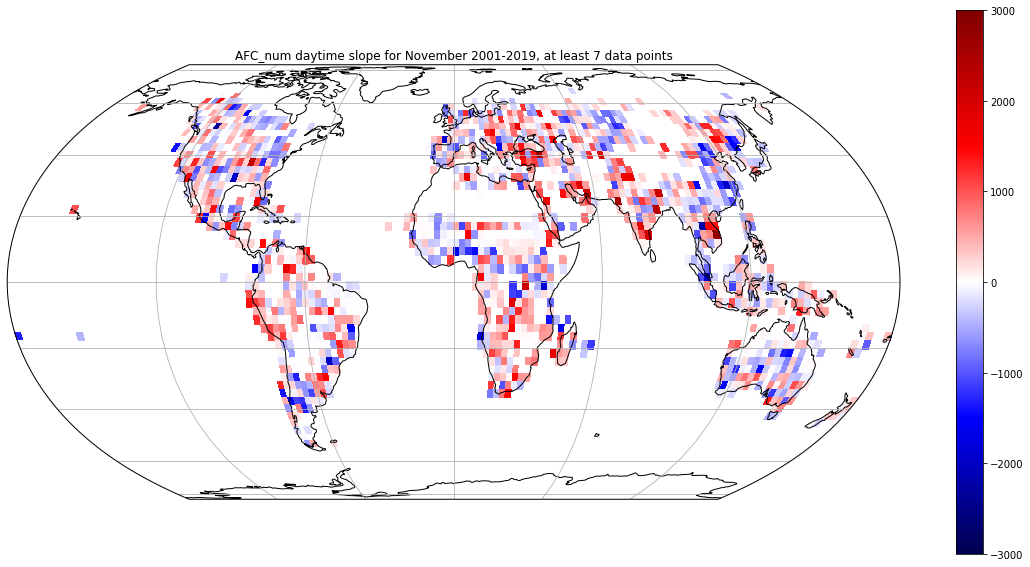

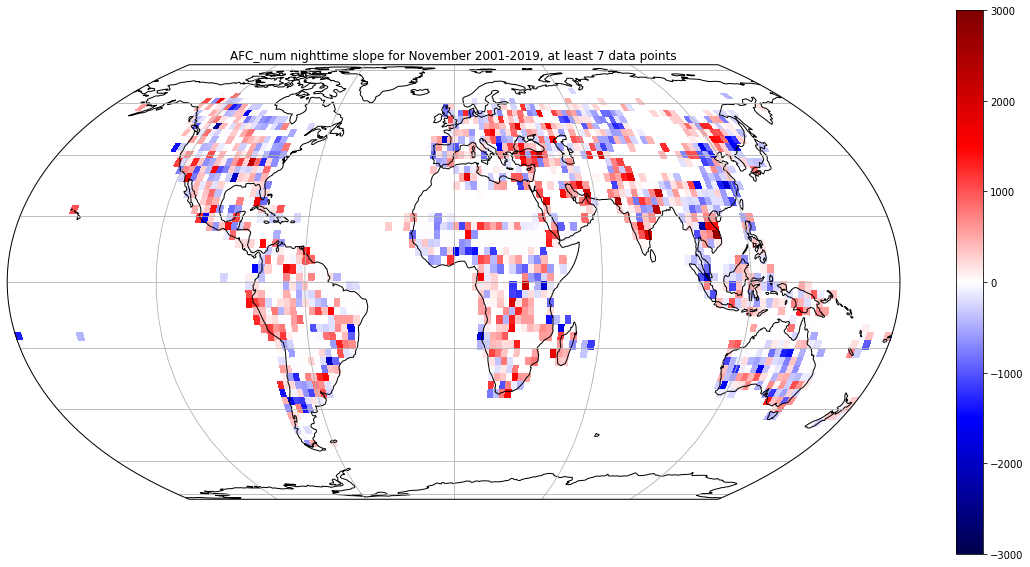

*************************************************


In [23]:
raster_folder = r"D:/projects/RD/night_fire/vars/grid_2_5_degree_vars/" # data refresh!

var = 'AFC_num'
n=7
fig_folder = r"D:/projects/RD/night_fire/figs/slopes_refresh/{}_2_5_numobs{}".format(var,n)

if not os.path.exists(fig_folder):
    os.makedirs(fig_folder)
    
cm = 'seismic'
for month in ['April', 'May', 'June', 'July', 'August', 'September', 'October', 'November']:
    print('*************************************************')
    plot_regress_var(raster_folder, af_var='AFC_num', reg_month=month, reg_var='slope', n_obsv=n, agg_fact=1,
                    absmin=-3000, 
                    absmax=3000,
                    cm=cm,
                    save=True,
                    save_dir=fig_folder,
                    cartoplot=True)
    print('*************************************************')

## use cartopy

In [6]:
var = 'AFC_num'
month = 'June'
n_obsv=10
day_rasters = glob(raster_folder + '{}/*_D_*{}*.tif'.format(var, month))
night_rasters = glob(raster_folder + '{}/*_N_*{}*.tif'.format(var, month))
years = [int(os.path.basename(d).split('.')[0].split('_')[-1]) for d in day_rasters]

test_day = xr.DataArray(stack(day_rasters, nodata=0)[0], dims=['time', 'lat', 'lon'])
test_night = xr.DataArray(stack(night_rasters, nodata=0)[0], dims=['time', 'lat', 'lon'])
test_years = xr.DataArray(np.arange(2001,2001+test_night.shape[0]), dims=['time'])

d_cov, d_cor, d_slope, d_intercept, d_pval, d_stderr, d_n = lag_linregress_3D(test_years, test_day, n_obs=n_obsv)
n_cov, n_cor, n_slope, n_intercept, n_pval, n_stderr, n_n = lag_linregress_3D(test_years, test_night, n_obs=n_obsv)


C:\software\anaconda3\envs\eapy_gbdx\lib\site-packages\scipy\stats\_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\software\anaconda3\envs\eapy_gbdx\lib\site-packages\scipy\stats\_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\software\anaconda3\envs\eapy_gbdx\lib\site-packages\scipy\stats\_distn_infrastructure.py:1831: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


In [7]:
np.mean(d_slope - n_slope)

<xarray.DataArray ()>
array(0.002884)

# MISCELLANEOUS ATTEMPTS

# try with xarray

In [8]:
xdata = n_slope.copy()
xdata = xr.DataArray(n_slope, coords=[tlat, tlon], dims=['lat', 'lon'])
# xdata[xdata==0] = np.nan
xdata = xr.where(xdata == 0, np.nan, xdata)

fig = plt.figure(figsize=(20,10))
ax = plt.axes(projection=ccrs.EqualEarth())
ax.set_global()
ax.coastlines()
ax.gridlines()
xdata.plot(ax=ax, transform=ccrs.PlateCarree(), cmap='jet')
plt.title('title')
           #vmin=2, vmax=30, cbar_kwargs={'shrink': 0.4})

NameError: name 'tlat' is not defined

In [9]:
# vars: ['AFC_num', 'AFC_perc', 'FRP_max', 'FRP_mean', 'FRP_total']
var = 'AFC_num'
month='August'
day_rasters = glob(raster_folder + '{}/*_D_*{}*.tif'.format(var, month))
night_rasters = glob(raster_folder + '{}/*_N_*{}*.tif'.format(var, month))
years = [int(os.path.basename(d).split('.')[0].split('_')[-1]) for d in day_rasters]

test_day = xr.DataArray(stack(day_rasters, nodata=0)[0], dims=['time', 'lat', 'lon'])
test_night = xr.DataArray(stack(night_rasters, nodata=0)[0], dims=['time', 'lat', 'lon'])
test_years = xr.DataArray(np.arange(2001,2001+test_night.shape[0]), dims=['time'])

In [10]:
n_obsv = 7
d_cov, d_cor, d_slope, d_intercept, d_pval, d_stderr, d_n = lag_linregress_3D(test_years, test_day, n_obs=n_obsv)
n_cov, n_cor, n_slope, n_intercept, n_pval, n_stderr, n_n = lag_linregress_3D(test_years, test_night, n_obs=n_obsv)

In [11]:
absmin = min(n_slope.min(), d_slope.min())
absmax = min(n_slope.max(), d_slope.max())

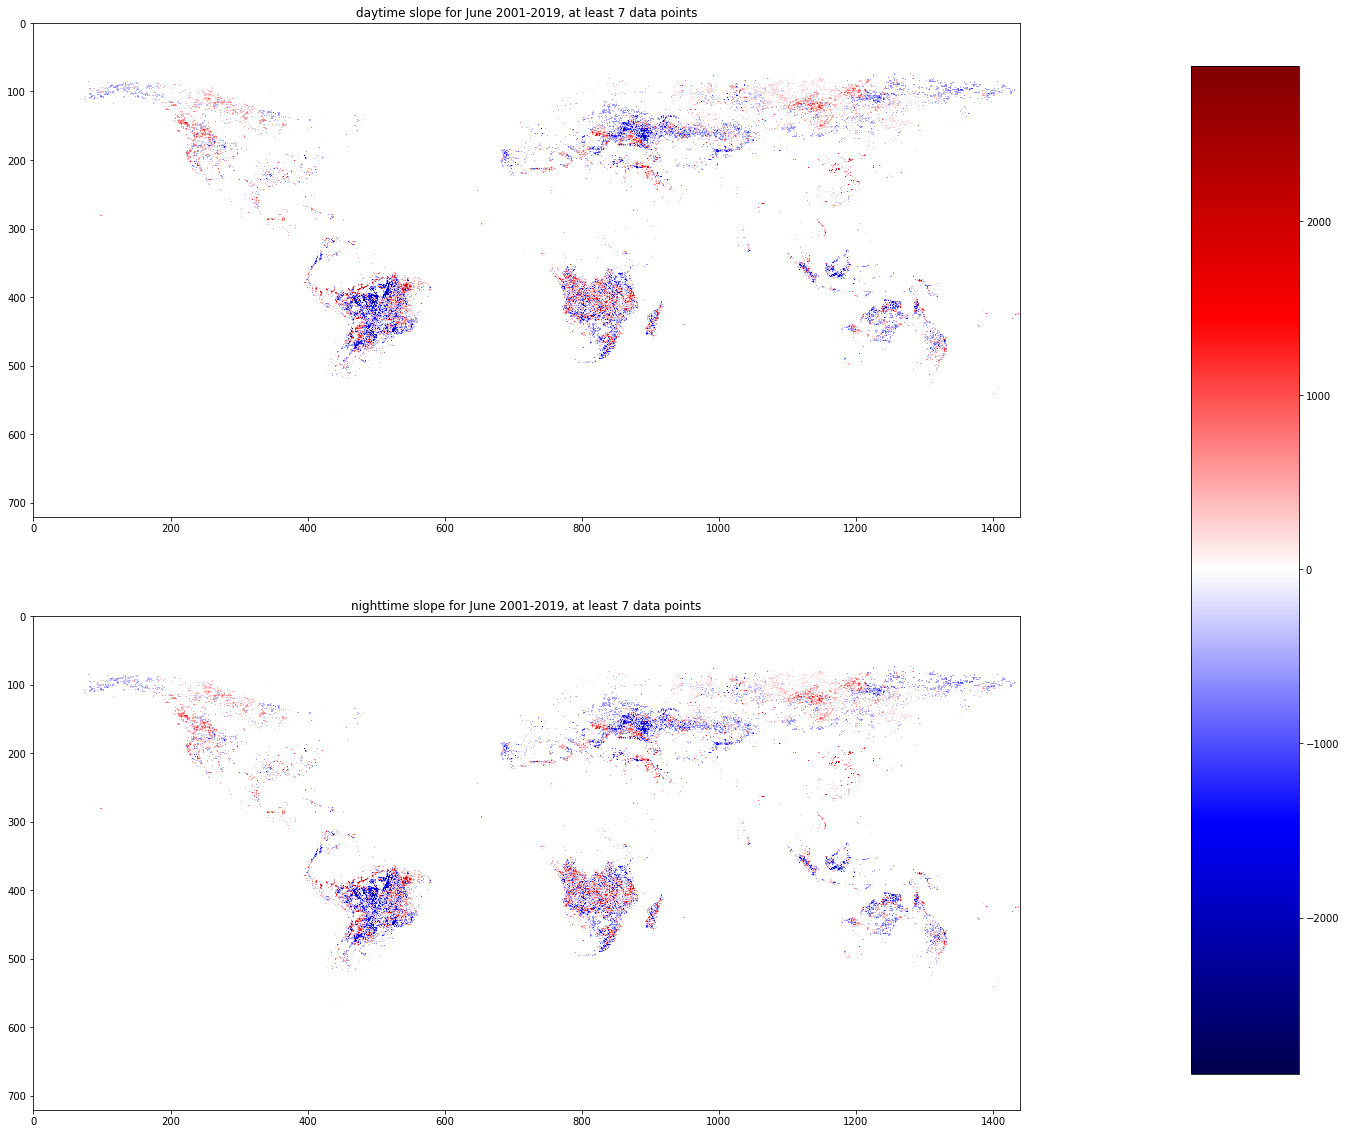

In [13]:
night_plot_im = np.ma.masked_equal(n_slope,0)
day_plot_im = np.ma.masked_equal(d_slope,0)


# aggregate?
agg_fac = 1 # agg_fac*0.25... 4 == 1 deg
night_resized = resize(night_plot_im, (int(night_plot_im.shape[0] / agg_fac), int(night_plot_im.shape[1] / agg_fac)), anti_aliasing=True)
night_resized = np.ma.masked_equal(night_resized,0)

day_resized = resize(day_plot_im, (int(day_plot_im.shape[0] / agg_fac), int(day_plot_im.shape[1] / agg_fac)), anti_aliasing=True)
day_resized = np.ma.masked_equal(day_resized,0)

fig, ax = plt.subplots(2,1, figsize=(30,20))
ax[0].imshow(day_resized, cmap='seismic', vmin=absmin, vmax=absmax)
ax[0].set_title('daytime slope for June 2001-2019, at least {} data points'.format(n_obsv))
im=ax[1].imshow(night_resized, cmap='seismic', vmin=absmin, vmax=absmax)
ax[1].set_title('nighttime slope for June 2001-2019, at least {} data points'.format(n_obsv))

fig.subplots_adjust(right=0.96)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)

plt.show()



## do em all!

In [5]:
raster_folder = '../grid_0_25_degree_vars_2/'
months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
out_folder = '../slopes_grid_0_25_degree_vars_2/slopes_month/'

# load spatial metadata for raster writing
with open('climate_grid_meta_0_25_wgs84.pickle', 'rb') as fp:
    meta = pickle.load(fp)

absmin=-80
absmax=50

for var in ['AFC_num', 'AFC_perc', 'FRP_max', 'FRP_mean', 'FRP_total']:
    for n_obsv in range(5,20):

        out_folder = '../slopes_grid_0_25_degree_vars_2/slopes_month/slopes_{}_month_numpts_{}/'.format(var, n_obsv)
        if not os.path.exists(out_folder):
            os.makedirs(out_folder)

        for month in months:
            day_rasters = glob(raster_folder + '{}/*_D_*{}*.tif'.format(var, month))
            night_rasters = glob(raster_folder + '{}/*_N_*{}*.tif'.format(var, month))
            years = [int(os.path.basename(d).split('.')[0].split('_')[-1]) for d in day_rasters]

            test_day = xr.DataArray(stack(day_rasters, nodata=0)[0], dims=['time', 'lat', 'lon'])
            test_night = xr.DataArray(stack(night_rasters, nodata=0)[0], dims=['time', 'lat', 'lon'])
            test_years = xr.DataArray(years, dims=['time'])

            d_cov, d_cor, d_slope, d_intercept, d_pval, d_stderr, d_n = lag_linregress_3D(test_years, test_day, n_obs=n_obsv)
            n_cov, n_cor, n_slope, n_intercept, n_pval, n_stderr, n_n = lag_linregress_3D(test_years, test_night, n_obs=n_obsv)

            absmin = min(n_slope.min(), d_slope.min())
            absmax = min(n_slope.max(), d_slope.max())

    #         fig, ax = plt.subplots(2,1, figsize=(30,20))
    #         ax[0].imshow(d_slope, cmap='PuOr', vmin=absmin, vmax=absmax)
    #         ax[0].set_title('daytime slope for {} {}-{}'.format(month, min(years), max(years)))
    #         im=ax[1].imshow(n_slope, cmap='PuOr', vmin=absmin, vmax=absmax)
    #         ax[1].set_title('nighttime slope for {} {}-{}'.format(month, min(years), max(years)))

    #         fig.subplots_adjust(right=0.96)
    #         cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
    #         fig.colorbar(im, cax=cbar_ax)

    #         plt.show()

    #         print('****************************************************************************************')
    #         print('****************************************************************************************')

            # save the slope as raster
            fname = 'modis_D_slope_{}_{}_{}_{}_numpts_{}.tif'.format(var, month, min(years), max(years), n_obsv)
            fpath = os.path.join(out_folder, fname)
            with rio.open(fpath, 'w', **meta) as dst:
                dst.write(np.expand_dims(d_slope,0).astype('float32'))

            fname = 'modis_N_slope_{}_{}_{}_{}_numpts_{}.tif'.format(var, month, min(years), max(years), n_obsv)
            fpath = os.path.join(out_folder, fname)
            with rio.open(fpath, 'w', **meta) as dst:
                dst.write(np.expand_dims(n_slope,0).astype('float32'))